<a href="https://colab.research.google.com/github/wangjalen7/project_chd/blob/main/CHD_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Jalen's Model

## Data Cleaning

In [1]:
import pandas as pd

train_data_path = './data/fhs_train_jalen.csv'
test_data_path = './data/fhs_test_jalen.csv'

train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)

train_data.head(), train_data.describe(), train_data.info(), test_data.head(), test_data.describe(), test_data.info()


FileNotFoundError: [Errno 2] No such file or directory: './data/fhs_train_jalen.csv'

In [ ]:
# Drop first unnamed column from both datasets
train_data.drop(columns='Unnamed: 0', inplace=True)
test_data.drop(columns='Unnamed: 0', inplace=True)

# Impute missing values
# For continuous variables, used median to avoid the effect of outliers.
# For categorical variables, used mode.
categorical_cols = ['education', 'BPMeds']
continuous_cols = ['cigsPerDay', 'totChol', 'BMI', 'glucose']

# Impute training data
for col in categorical_cols:
    mode_value = train_data[col].mode()[0]
    train_data[col].fillna(mode_value, inplace=True)

for col in continuous_cols:
    median_value = train_data[col].median()
    train_data[col].fillna(median_value, inplace=True)

# Impute testing data the same way to keep consistent
for col in categorical_cols:
    mode_value = test_data[col].mode()[0]
    test_data[col].fillna(mode_value, inplace=True)

for col in continuous_cols:
    median_value = test_data[col].median()
    test_data[col].fillna(median_value, inplace=True)

train_missing_after = train_data.isnull().sum().sum()
test_missing_after = test_data.isnull().sum().sum()

train_missing_after, test_missing_after


(0, 1)

In [ ]:
# Impute the remaining missing value in the testing data
test_data['heartRate'].fillna(test_data['heartRate'].median(), inplace=True)

test_missing_final = test_data.isnull().sum().sum()

test_missing_final


0

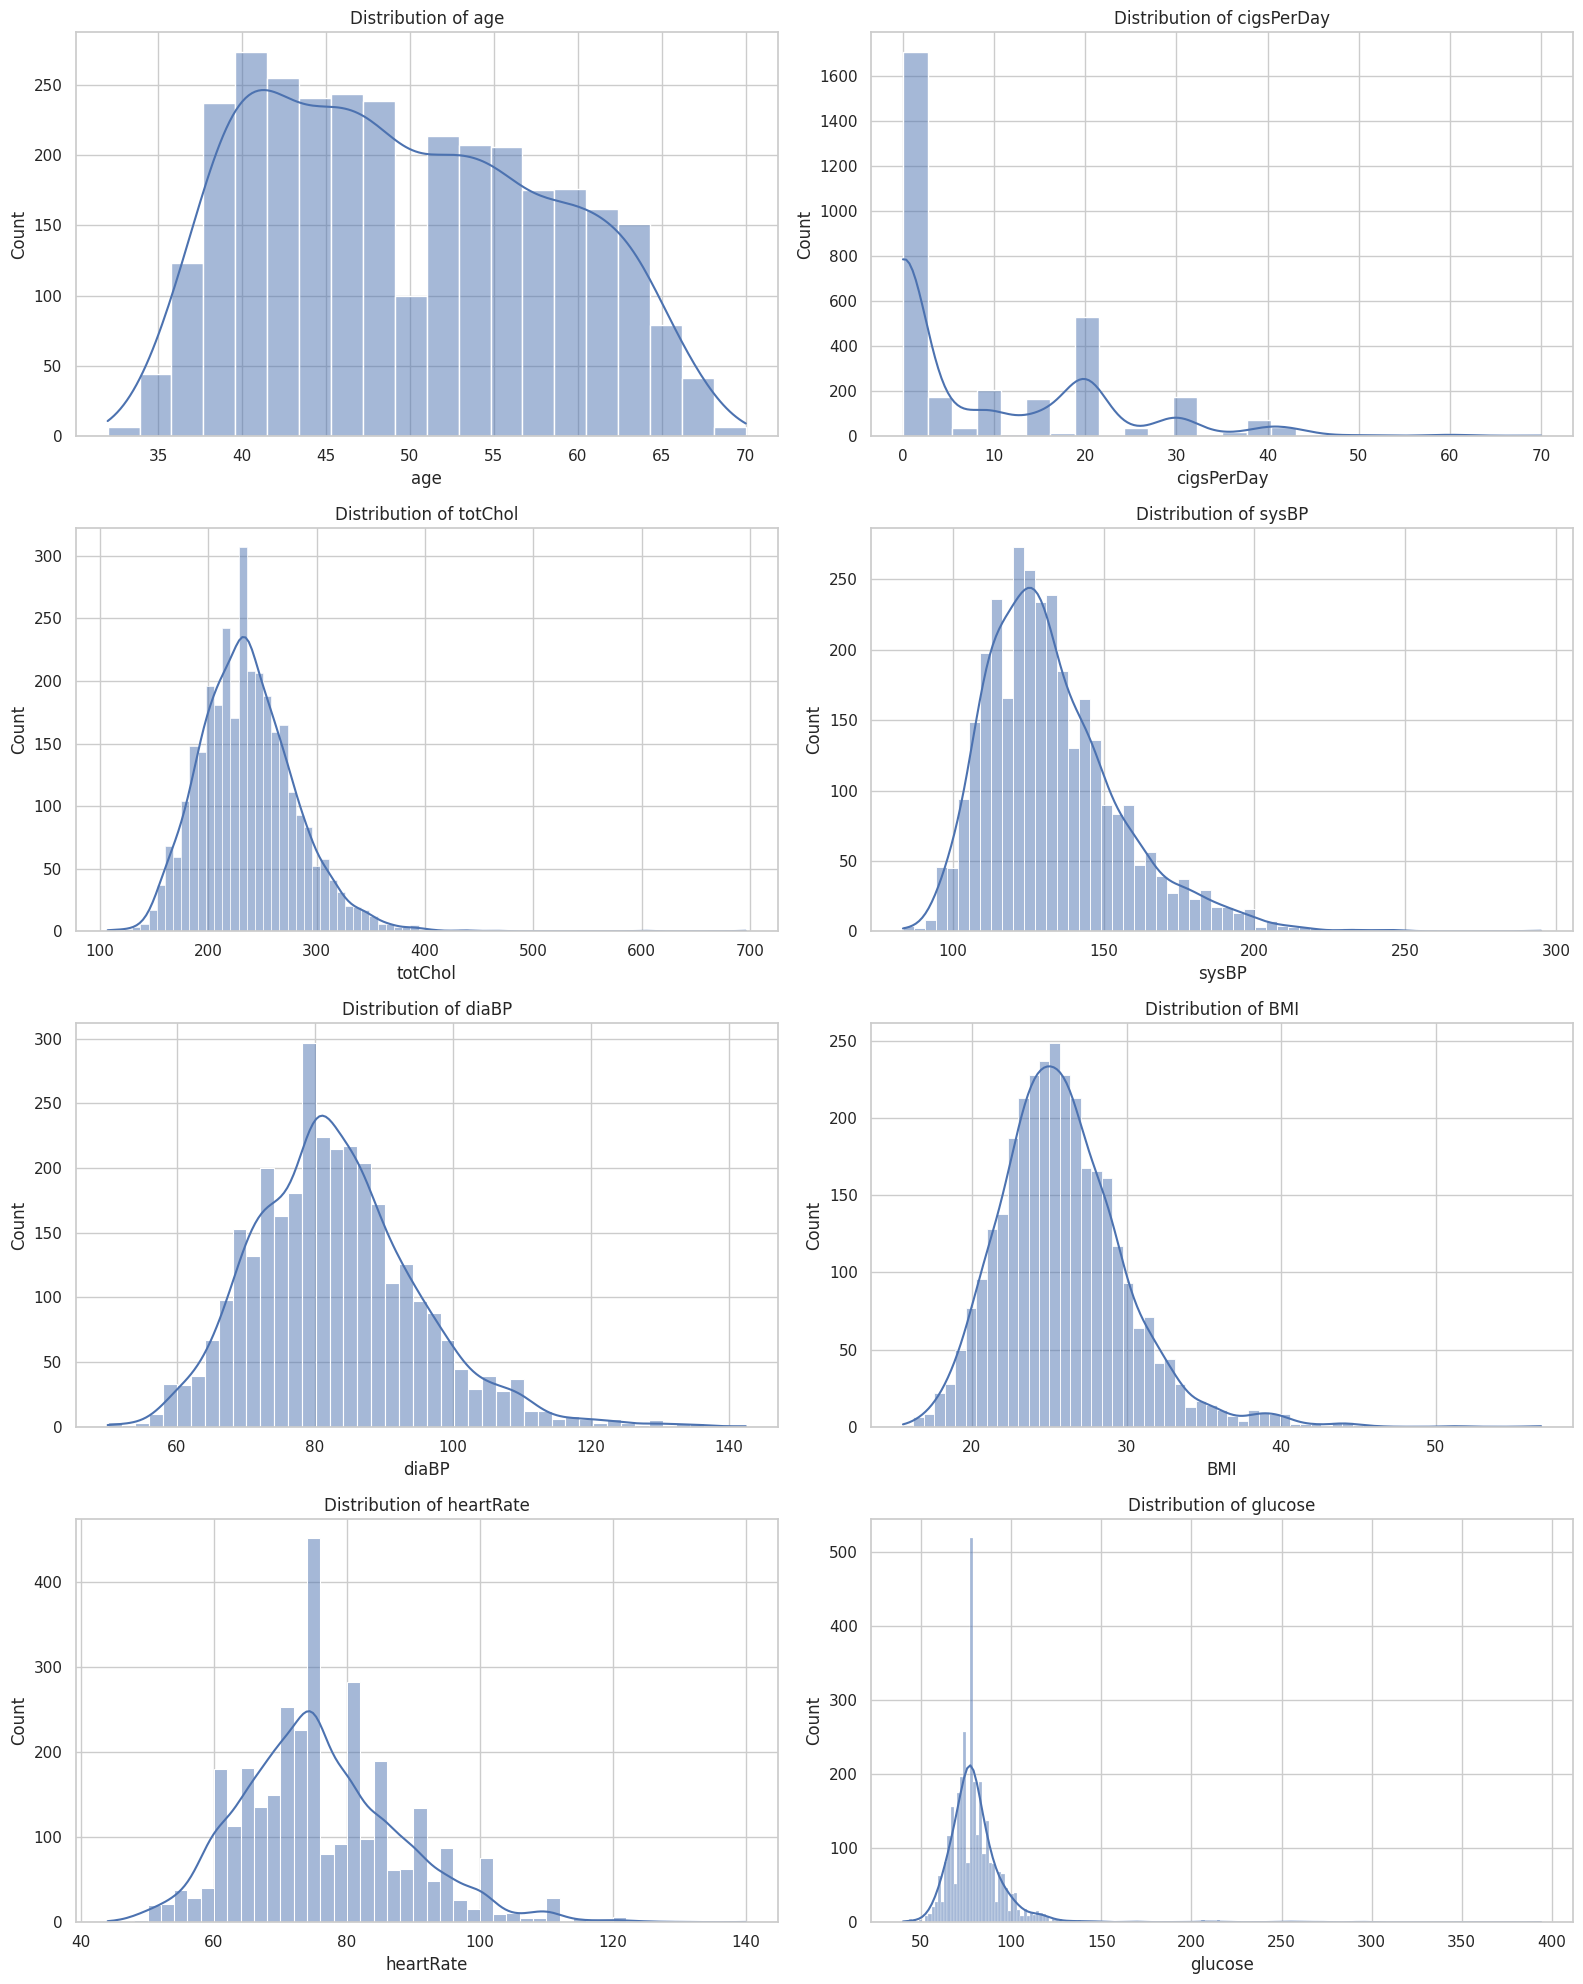

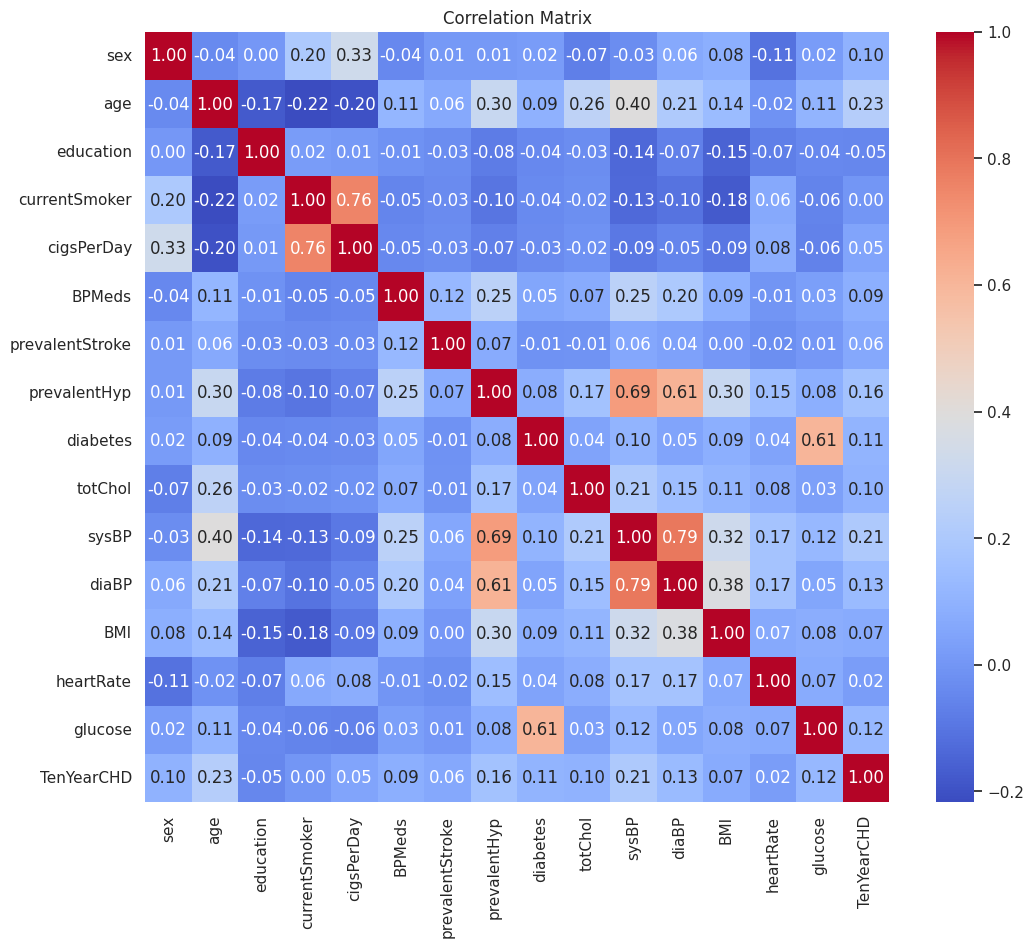

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(16, 20))
cont_columns = ['age', 'cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']
for i, col in enumerate(cont_columns):
    sns.histplot(train_data[col], kde=True, ax=axes[i//2, i%2])
    axes[i//2, i%2].set_title(f'Distribution of {col}')

fig.tight_layout()
plt.show()

corr_matrix = train_data.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


## K-Nearest Neigbors Model

In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, r2_score

import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
# Extract features and target variable from the training dataset
X = train_data.drop('TenYearCHD', axis=1)
y = train_data['TenYearCHD']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Splitting data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Grid search to find the optimal k using cross-validation
param_grid_knn = {'n_neighbors': list(range(1, 31))}
knn_grid_search = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=5, scoring='roc_auc', return_train_score=True)
knn_grid_search.fit(X_train, y_train)

# Best parameters and the corresponding score
optimal_k = knn_grid_search.best_params_['n_neighbors']
best_score = knn_grid_search.best_score_

optimal_k, best_score


(30, 0.6735462826105305)

In [ ]:
# Setup KNN with the optimal number of neighbors
optimal_knn_model = KNeighborsClassifier(n_neighbors=optimal_k)

# Train the model on the entire scaled training data
optimal_knn_model.fit(X_scaled, y)

# Prepare test data (scaling)
X_test = test_data.drop('TenYearCHD', axis=1)
y_test = test_data['TenYearCHD']
X_test_scaled = scaler.transform(X_test)  # Use the same scaler as for training data

# Predict probabilities on the test set
y_test_pred_proba_knn = optimal_knn_model.predict_proba(X_test_scaled)[:, 1]

# Calculate ROC AUC and R² scores for the KNN model on the test data
roc_auc_test_knn = roc_auc_score(y_test, y_test_pred_proba_knn)
r2_test_knn = r2_score(y_test, y_test_pred_proba_knn)

roc_auc_test_knn, r2_test_knn


(0.6684688688095591, 0.044475637158202574)

# Decision Tree Approach (Tyler)

In [3]:
# path of the data
train_data_path = "./data/fhs_train.csv"
test_data_path = "./data/fhs_test.csv"

train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)

train_data.head()

,Unnamed: 0,sex,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1267,1,58,1.0,0,0.0,0.0,0,0,0,220.0,143.0,104.0,29.85,75,87.0,1
1,1209,0,40,1.0,1,15.0,0.0,0,0,0,199.0,122.0,82.0,22.16,85,77.0,0
2,2050,0,52,1.0,0,0.0,0.0,0,0,0,275.0,112.0,71.0,25.68,80,NaN,0
3,1183,1,38,2.0,1,43.0,0.0,0,1,0,170.0,130.0,94.0,23.90,110,75.0,0
4,3225,0,43,1.0,0,0.0,0.0,0,0,0,202.0,124.0,92.0,21.26,75,74.0,0


## **EDA**

In [4]:
# get the shapes of the dataset
print("Shape of training data:", train_data.shape)
print("Shape of Test Data:", test_data.shape)

Shape of training data: (3180, 17)
Shape of Test Data: (1060, 17)


In [8]:
# correlation matrix
corr_matrix = train_data.corr()
print(corr_matrix['TenYearCHD'].sort_values(ascending = False))

TenYearCHD         1.000000
age                0.225568
sysBP              0.205898
prevalentHyp       0.163910
diaBP              0.133094
glucose            0.126485
diabetes           0.105644
totChol            0.099704
sex                0.097138
BPMeds             0.088135
BMI                0.072830
prevalentStroke    0.062357
cigsPerDay         0.047712
heartRate          0.023205
currentSmoker      0.001644
Unnamed: 0        -0.019496
education         -0.052668
Name: TenYearCHD, dtype: float64


The first step was creating a correlation matrix to see which values seem to correlate the most with `TenYearCHD` variable. The correlation matrix seems to indicate that `age`, `sysBP`, `prevalentHyp`, `diaBP`, `glucose`, and `diabetes` have the highest correlations above `0.09`.